In [2]:
import os
import math
import config
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import (
    create_img_grid,
    SpatialProjection
)

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

sns.set_style()

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 22,
    "text.color": "#212121",
    "axes.edgecolor": "#212121",
    "xtick.color": "#212121",
    "ytick.color": "#212121",
    "axes.labelcolor": "#212121",
    'legend.frameon': False,
})


In [19]:
data_dir = "../../data/dataset/raw/"
images_dir = "../../data/dataset/images/"
subjects = os.listdir(data_dir)

IMG_LEN = 225

# sp = SpatialProjection(
#     img_dir="../../data/dataset/images/",
#     img_len=math.floor(IMG_LEN / 3),
#     polyfit_degree=0
# )

augmentation_levels = [0, 7, 9, 11, 13]
sp_augment = [
    SpatialProjection(
    img_dir="../../data/dataset/images/",
    # img_len=math.floor(config.IMG_LEN / 3),
    img_len=config.IMG_LEN,
    polyfit_degree=degree
)
    for degree in augmentation_levels ]


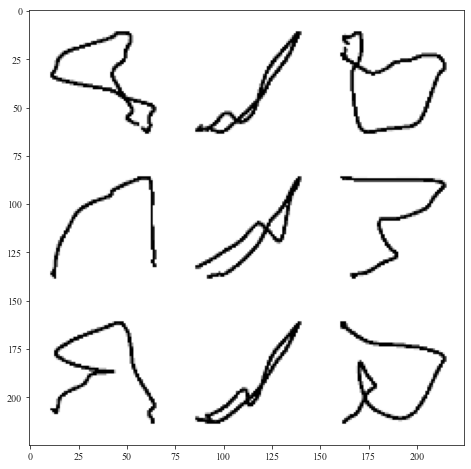

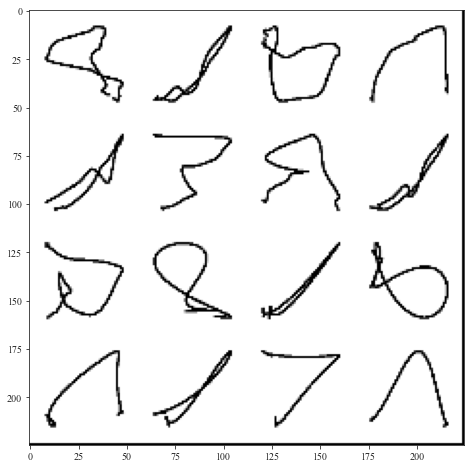

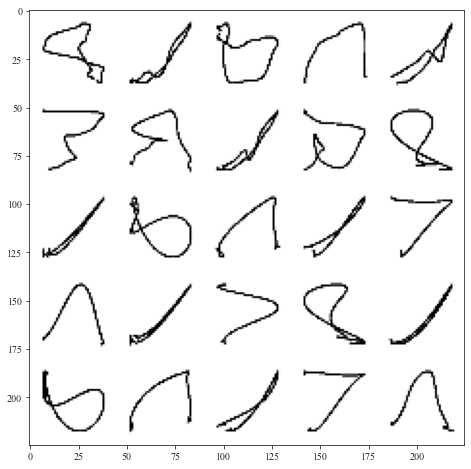

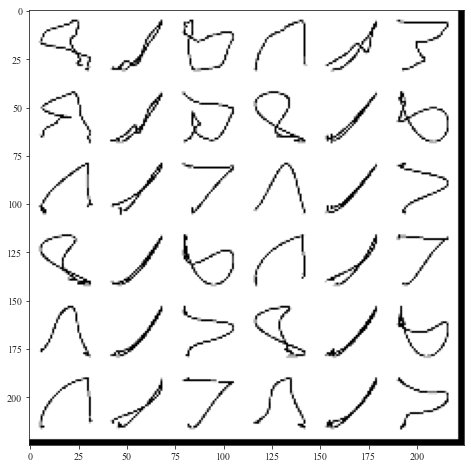

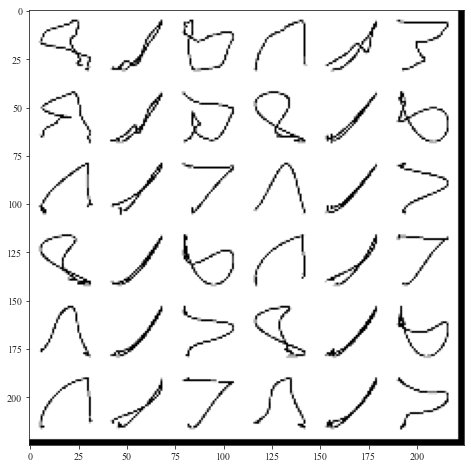

In [20]:
images = []
labels = []



for subject in subjects:
    for gesture in config.GESTURES:
        gesture_dir = os.path.join(data_dir, subject, gesture)

        recordings = []
        try:
            recordings = os.listdir(gesture_dir)
        except FileNotFoundError:
            continue

        for recording in recordings:
            _images = []
            file_path = os.path.join(gesture_dir, recording)

            data = pd.read_csv(file_path)
            data.drop(columns=["time"], inplace=True)
            data.drop(0, inplace=True)  # Remove first All-0 row

            for sp in sp_augment:
                for landmark in config.PROJECTION_LANDMARKS:
                    _images.extend(
                        sp.get_projection_images(
                            data=data.filter(regex=landmark),
                            subject=subject,
                            gesture=gesture
                        )
                    )

                img = create_img_grid(_images, IMG_LEN)

                images.append(img)
                labels.append(config.GESTURES.index(gesture))

                plt.figure(figsize=(8, 8))
                plt.imshow(img)
                # plt.title(f"Original Spatial Projection")
                save_path = os.path.join(images_dir, subject, gesture)
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                # plt.savefig(os.path.join(save_path, recording + ".jpg"))
                # plt.close()
                # plt.axis("off")
                # plt.tight_layout()
                # plt.savefig("../assets/projection_demo.svg")
                plt.show()
            
            break
        break
    break

# Trajectories

In [21]:
from utils import LowPassFilter

def get_ployfit_approximation(
    data: np.ndarray,
    polyfit_degree: int = 9
) -> np.ndarray:
    processed_data = data.to_numpy().ravel()

    if polyfit_degree == 0:
        # ... First few (10) datapoints contains filter artifacts
        processed_data = LowPassFilter.apply(processed_data)[10:]
    else:
        t = np.linspace(0, 1, processed_data.shape[0])
        f = np.poly1d(np.polyfit(t, processed_data, polyfit_degree))
        processed_data = f(t)

    return processed_data

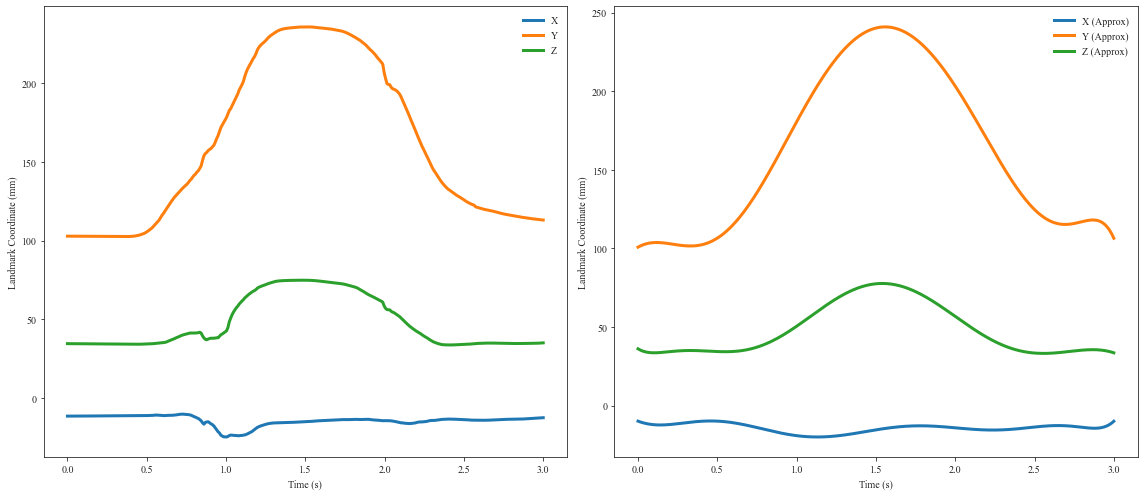

In [22]:


x = data["rpx"]
y = data["rpy"]
z = data["rpz"]

_x = get_ployfit_approximation(x)
_y = get_ployfit_approximation(y)
_z = get_ployfit_approximation(z)

t = np.linspace(0, 3, x.shape[0])

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)

plt.plot(t, x, label="X", linewidth=3)
plt.plot(t, y, label="Y", linewidth=3)
plt.plot(t, z, label="Z", linewidth=3)
plt.xlabel("Time (s)")
plt.ylabel("Landmark Coordinate (mm)")
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(t, _x, label="X (Approx)", linewidth=3)
plt.plot(t, _y, label="Y (Approx)", linewidth=3)
plt.plot(t, _z, label="Z (Approx)", linewidth=3)
plt.xlabel("Time (s)")
plt.ylabel("Landmark Coordinate (mm)")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/polyfit_approx.svg")